# Variational Autoencoders with PyTorch

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.1448, 0.1900, 0.5188],
        [0.2220, 0.8916, 0.1754],
        [0.0359, 0.1372, 0.1626],
        [0.6022, 0.7164, 0.8794],
        [0.3810, 0.8717, 0.9364]])

## **Load Data**

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

root = "./data"
!mkdir root

transformations = transforms.Compose([ transforms.ToTensor() ])
mnist_train = datasets.MNIST(root, train=True, transform=transformations, target_transform=None, download=True)
mnist_test = datasets.MNIST(root, train=False, transform=transformations, target_transform=None, download=True)

BATCH_SIZE = 32
CUDA = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

## **VAE Code**

In [5]:
%load_ext tensorboard.notebook
from tensorboardX import SummaryWriter
from torch.autograd import Variable
from torch.nn import functional as F
from torch import optim
from torch import nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(784,400)
        self.relu = nn.ReLU()
        self.l21 = nn.Linear(400, latent_dim)
        self.l22 = nn.Linear(400, latent_dim)    
  
    def forward(self, x):
        x1 = self.relu(self.l1(x))
        return self.l21(x1), self.l22(x1)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.l3 = nn.Linear(latent_dim, 400)
        self.relu = nn.ReLU()
        self.l4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        x1 = self.relu(self.l3(x))
        return self.sigmoid(self.l4(x1))
    
def sample(mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)

def vae_loss(x, x_hat, mu, logvar):
    MSE = F.mse_loss(x_hat, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 784
    return MSE, KLD

## **Training code**

In [10]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10, writer=None):
    i = 0
    interval = 50
    for epoch in range(num_epochs):
        encoder.train(mode=True)
        decoder.train(mode=True)
        
        for batch_idx, (x, _) in enumerate(train_loader):
            if CUDA:
                x = x.cuda()

            optimizer.zero_grad()
                
            mu, logvar = encoder(x.view(-1,784))
            x_hat = decoder(sample(mu, logvar))

            MSE, KLD = vae_loss(x, x_hat, mu, logvar)
            loss = MSE + KLD
            
            if i % interval == 0:
                writer.add_scalar("train/MSE", MSE.item(), i)
                writer.add_scalar("train/KLD", KLD.item(), i)
                writer.add_scalar("train/LOSS", loss.item(), i)
                
            i += 1
            
            loss.backward()
            optimizer.step()
            
        test(epoch, encoder, decoder, test_loader, writer)

def test(epoch, encoder, decoder, test_loader, writer=None):    
    total_mse = .0
    total_kld = .0
    total_loss = .0
    num_batches = 0
    
    img_save_interval = 100
    i = 0
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            if CUDA:
                x = x.cuda()

            mu, logvar = encoder(x.view(-1,784))
            x_hat = decoder(sample(mu, logvar))
            
            MSE, KLD = vae_loss(x, x_hat, mu, logvar)
            loss = MSE + KLD

            total_mse += MSE.item()
            total_kld += KLD.item()
            total_loss += loss.item()
            
            num_batches += 1
            
            if i % img_save_interval == 0:
                zipped = list(zip(x, x_hat))
                for x, x_hat in zipped:
                    writer.add_image("image/x-".join(str(i)), x, epoch)
                    writer.add_image("image/x_hat-".join(str(i)), x_hat.view(1,28,28), epoch)
                
            i += 1
            
    writer.add_scalar("test/total_MSE", total_mse, epoch)
    writer.add_scalar("test/total_KLD", total_kld, epoch)
    writer.add_scalar("test/total_LOSS", total_loss, epoch)

    writer.add_scalar("test/avg_MSE", total_mse/ num_batches, epoch)
    writer.add_scalar("test/avg_KLD", total_kld / num_batches, epoch)
    writer.add_scalar("test/avg_LOSS", total_loss / num_batches, epoch)

### Logger

In [ ]:
logsdir = "./logs/vae"
!rm -rf logsdir
writer = SummaryWriter(logsdir)

### Init VAE

In [ ]:
LATENT_DIM = 20
encoder = Encoder(LATENT_DIM)
decoder = Decoder(LATENT_DIM)
if CUDA:
    encoder.cuda()
    decoder.cuda()
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

### Start training

In [11]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 10, writer = writer)
writer.close()

## **Interpolation**

In [12]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def interpolate(A, B, n):
    return A.add(B.sub(A).mul(n/8))

def create_interpolates(A, B, encoder, decoder):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        a_mu, a_logvar = encoder(A.view(-1,784))
        a_sample = sample(a_mu, a_logvar)
        
        b_mu, b_logvar = encoder(B.view(-1,784))
        b_sample = sample(b_mu, b_logvar)
        interpolates = decoder(a_sample)
        
        for n in range(1, 9):
            inter = interpolate(a_sample, b_sample, n)
            decoded = decoder(inter)
            interpolates = torch.cat((interpolates, decoded), 0)

    return interpolates

### **Interpolation of similar pairs**

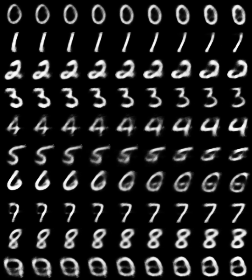

In [13]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
    for i in range(len(y)):
        if y[i].item() not in similar_pairs:
            similar_pairs[y[i].item()] = []
        if len(similar_pairs[y[i].item()])<2:
            similar_pairs[y[i].item()].append(x[i])

    done = True
    for i in range(10):
        if i not in similar_pairs or len(similar_pairs[i])<2:
            done = False
  
    if done:
        break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i

from torchvision.utils import save_image
from IPython.display import Image

interpolates = torch.zeros((10,9,28,28))

for i in similar_pairs:
    A, B = similar_pairs[i]
    if CUDA:
        A = A.cuda()
        B = B.cuda()
 
    interpolates[i] = create_interpolates(A, B, encoder, decoder).view(9,28,28)

save_image(interpolates.view(90,1,28,28), "img/similar_pairs.png", nrow=9, padding=0)
Image(filename="img/similar_pairs.png", width=252, height=280)

### **Interpolation of random pairs**

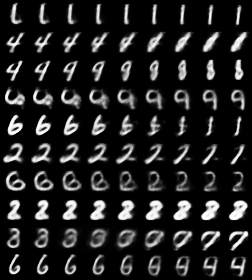

In [14]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
    # Make sure the batch size is greater than 20
    for i in range(10):
        random_pairs[i] = []
        random_pairs[i].append(x[2*i])
        random_pairs[i].append(x[2*i+1])
    break

# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

interpolates = torch.zeros((10,9,28,28))

for i in random_pairs:
    A, B = random_pairs[i]
    if CUDA:
        A = A.cuda()
        B = B.cuda()
        
    interpolates[i] = create_interpolates(A, B, encoder, decoder).view(9,28,28)

save_image(interpolates.view(90,1,28,28), "img/random_pairs.png", nrow=9, padding=0)
Image(filename="img/random_pairs.png", width=252, height=280)